In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/fact/1022.txt   
  inflating: dataset/fact/1023.txt   
  inflating: dataset/fact/1024.txt   
  inflating: dataset/fact/1025.txt   
  inflating: dataset/fact/1026.txt   
  inflating: dataset/fact/1027.txt   
  inflating: dataset/fact/1028.txt   
  inflating: dataset/fact/1029.txt   
  inflating: dataset/fact/103.txt    
  inflating: dataset/fact/1030.txt   
  inflating: dataset/fact/1031.txt   
  inflating: dataset/fact/1032.txt   
  inflating: dataset/fact/1033.txt   
  inflating: dataset/fact/1034.txt   
  inflating: dataset/fact/1035.txt   
  inflating: dataset/fact/1036.txt   
  inflating: dataset/fact/1037.txt   
  inflating: dataset/fact/1038.txt   
  inflating: dataset/fact/1039.txt   
  inflating: dataset/fact/104.txt    
  inflating: dataset/fact/1040.txt   
  inflating: dataset/fact/1041.txt   
  inflating: dataset/fact/1042.txt   
  inflating: dataset/fact/1043.txt   
  inflating: dataset/fact/1044.txt   

In [ ]:
import csv
import glob
import pandas as pd
import os

In [ ]:
dirpath = "./dataset"
outputpath = 'datasetcsv.csv'
columns_name =["news","label"]
output = open(outputpath,'w')
csvout = csv.DictWriter(output,columns_name)
csvout.writeheader()
count =0
folders_name = os.listdir(dirpath);
for folder in folders_name:
  files = os.listdir(dirpath + '/' + folder)
  for f in files :
    with open(dirpath + '/' + folder + '/' + f,encoding="utf8",errors="ignore")as afile:
      text_file = afile.read().replace('\n','')
      row = {'news': text_file,'label': folder}
      csvout.writerow(row)
output.close()

In [ ]:
!pip install hazm

In [ ]:
import hazm
import re

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00


In [ ]:
!pip install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00


In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features
from transformers import AutoConfig, AutoTokenizer
from transformers import TFAutoModelForMaskedLM

import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


# Read the CSV file
df = pd.read_csv('datasetcsv.csv')
df.dropna(inplace=True)
labels = list(sorted(df['label'].unique()))
df['label_id'] = df['label'].apply(lambda t: labels.index(t))
# Split the dataset into train, validation, and test sets
train, test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

# Load the ALBERT tokenizer and model
MODEL_NAME = "m3hrdadfi/albert-fa-base-v2-clf-digimag"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Tokenize and prepare data for training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16

def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LEN)

x_train = tokenize_text(train['news'].tolist())
x_valid = tokenize_text(valid['news'].tolist())
x_test = tokenize_text(test['news'].tolist())

y_train = train['label_id'].values
y_valid = valid['label_id'].values
y_test = test['label_id'].values

x_train = {key: np.array(val) for key, val in x_train.items()}
x_valid = {key: np.array(val) for key, val in x_valid.items()}
x_test = {key: np.array(val) for key, val in x_test.items()}

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(TRAIN_BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(VALID_BATCH_SIZE)

# Compile and train the model
EPOCHS = 2
LEARNING_RATE = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS)

# Evaluate the model on the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(VALID_BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Some layers from the model checkpoint at m3hrdadfi/albert-fa-base-v2-clf-digimag were not used when initializing TFAlbertForSequenceClassification: ['dropout_7']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2-clf-digimag.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassification for predictions without further training.


Epoch 1/2
227/227 [==============================] - 132s 452ms/step - loss: 0.3838 - accuracy: 0.8620 - val_loss: 0.3159 - val_accuracy: 0.8806
Epoch 2/2
63/63 [==============================] - 10s 158ms/step - loss: 0.3379 - accuracy: 0.8846
Test Loss: 0.3379
Test Accuracy: 0.8846


In [ ]:
model.summary()

Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  18083584  
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 18,088,967
Trainable params: 18,088,967
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [ ]:
predictions = model.predict(x_test)
ypred = predictions[0].argmax(axis=-1).tolist()

print()
print(classification_report(y_test, ypred, target_names=labels))
print()

print(f'F1: {f1_score(y_test, ypred, average="weighted")}')

32/32 [==============================] - 18s 308ms/step

              precision    recall  f1-score   support

        fact       0.91      0.93      0.92       502
        fake       0.93      0.91      0.92       503

    accuracy                           0.92      1005
   macro avg       0.92      0.92      0.92      1005
weighted avg       0.92      0.92      0.92      1005


F1: 0.9184034361764254


<Axes: >

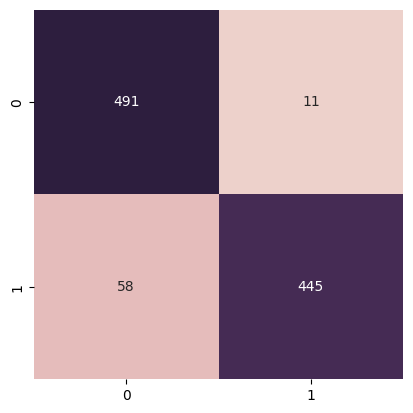

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
matrix_confusion = confusion_matrix(y_test, ypred)
sb.heatmap(matrix_confusion, square=True, annot=True, cmap=sb.cubehelix_palette(as_cmap=True)
, fmt='d', cbar=False)

In [ ]:
from tensorflow import keras

In [ ]:
model.save_weights('/content/gdrive/MyDrive/Albert/weights')

In [ ]:
with open('/content/1.txt') as f:
    lines = f.readlines()

In [ ]:
print(lines)

['سرپرست دانشگاه علوم پزشکی کهگیلویه و بویراحمد گفت: اغلب شهرهای استان از نظر وضعیت بیماری کرونا آبی هستند.']


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [ ]:
df1 = pd.DataFrame(columns=['text', 'label'])
df1.loc[0] = [lines[0], "fact"]
df1

,text,label
0,سرپرست دانشگاه علوم پزشکی کهگیلویه و بویراحمد ...,fact


In [ ]:
id_label_map = {
    'fact': 0,
    'fake': 1
}
df1['label'] = df1['label'].map(id_label_map)
df1

,text,label
0,سرپرست دانشگاه علوم پزشکی کهگیلویه و بویراحمد ...,0


In [ ]:
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LEN)

In [ ]:
MODEL_NAME = "m3hrdadfi/albert-fa-base-v2-clf-digimag"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16

In [ ]:
x_test1 = tokenize_text(df1['text'].tolist())
y_test1 = df1['label'].values
x_test1 = {key: np.array(val) for key, val in x_test1.items()}
test_dataset1 = tf.data.Dataset.from_tensor_slices((x_test1, y_test1)).batch(VALID_BATCH_SIZE)

In [ ]:
MODEL_NAME = "m3hrdadfi/albert-fa-base-v2-clf-digimag"
model2 = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at m3hrdadfi/albert-fa-base-v2-clf-digimag were not used when initializing TFAlbertForSequenceClassification: ['dropout_7']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2-clf-digimag.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassification for predictions without further training.


In [ ]:
model2.load_weights('/content/gdrive/MyDrive/Albert/weights')

In [ ]:
predictions = model2.predict(x_test1)
ypred1 = predictions[0].argmax(axis=-1).tolist()
print(ypred1)



1/1 [==============================] - 0s 58ms/step
[0]
